In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.optimize import brentq
from scipy.stats import pearsonr, spearmanr
import itertools

def nu2Rg(nus,Ns):
    b = .55
    g = 1.1615
    rgs = np.empty(0)
    for nu,N in zip(nus,Ns):
        rg = np.sqrt((g*g+g)/(g+2*nu)/(g+2*nu+1)/2)*b*np.power(N,nu)
        rgs = np.append(rgs, rg)
    return rgs

In [2]:
c = pd.read_pickle('calc.pkl')
p = pd.read_pickle('proteins.pkl')
r = pd.read_csv('residues.csv').set_index('one')
p = pd.concat([p,c],axis=1)
p['N'] = p.fasta.apply(lambda x : len(x))
#p['nullRg'] = p.N.apply(lambda x : 0.24*np.power(x,.53))
f = lambda x,a,b : a*np.power(x,b)
popt,_ = curve_fit(f,p.N,p.rg,p0=[.6,1])
popt

array([0.21403042, 0.55890677])

In [3]:
r = pd.read_csv('residues.csv').set_index('one')
df = pd.DataFrame(index=r.index,columns=p.index)
for name in p.index:
    counts = [p.loc[name].fasta.count(aa) for aa in r.index]
    freq = counts/np.sum(counts)
    df[name] = freq

0.5827755848766427 0.04244524297124585
0.5335882405778569 0.008824097955519479


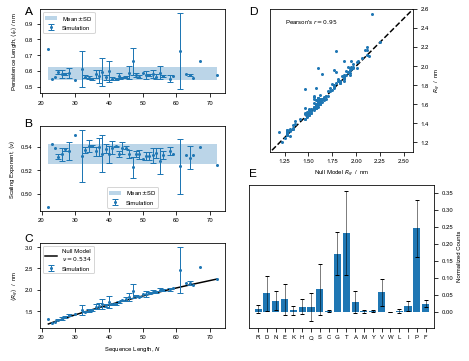

In [4]:
fig = plt.figure(figsize=(6.5,5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

ax1 = plt.subplot2grid( (6,2), (0,0), rowspan=2, colspan=1 )
ax2 = plt.subplot2grid( (6,2), (2,0), rowspan=2, colspan=1 )
ax3 = plt.subplot2grid( (6,2), (4,0), rowspan=2, colspan=1 )
ax4 = plt.subplot2grid( (6,2), (0,1), rowspan=3, colspan=1 )
ax5 = plt.subplot2grid( (6,2), (3,1), rowspan=3, colspan=1 )

# Average persistence lengths over sequences of equal length
df = p[['N','lp']].astype(float).groupby('N').agg([np.mean,np.std]).droplevel(0, axis=1)
ax1.errorbar(df.index,df['mean'],df['std'],lw=0,
        marker='o', ms=2, elinewidth=1, capsize=3, capthick=1,label='Simulation')
ax1.fill_between(df.index, df['mean'].mean()-df['mean'].std(), 
                 df['mean'].mean()+df['mean'].std(),alpha=.3, label='Mean$\pm$SD')
ax1.set_ylabel(r'Persistence Length, $\langle l_p \rangle$ / nm')
lp_mean = df['mean'].mean()
lp_sd = df['mean'].std()
print(lp_mean,lp_sd)

# Average scaling exponents over sequences of equal length
Nu = p[['N','nu_lp']].astype(float).groupby('N').agg([np.mean,np.std]).droplevel(0, axis=1)
ax2.errorbar(Nu.index,Nu['mean'],Nu['std'],lw=0,
        marker='o', ms=2, elinewidth=1, capsize=3, capthick=1,label='Simulation')
ax2.fill_between(Nu.index, Nu['mean'].mean()-Nu['mean'].std(), 
                 Nu['mean'].mean()+Nu['mean'].std(),alpha=.3, label='Mean$\pm$SD')
ax2.set_ylabel(r'Scaling Exponent, $\langle \nu \rangle$')
nu_mean = Nu['mean'].mean()
nu_sd = Nu['mean'].std()
print(nu_mean,nu_sd)

# Average radii of gyration over sequences of equal length
Rg = p[['N','rg']].astype(float).groupby('N').agg([np.mean,np.std]).droplevel(0, axis=1)
# Estimate the Rg based on sequence length and average scaling exponent
Rg['nullRg'] = nu2Rg([nu_mean]*Nu.index.size,Nu.index)
ax3.plot(Rg.index,Rg['nullRg'],color='k',label='Null Model\n'+r'$\nu={:.3f}$'.format(nu_mean))
ax3.errorbar(Rg.index,Rg['mean'],Rg['std'],lw=0,
        marker='o', ms=2, elinewidth=1, capsize=3, capthick=1,color='tab:blue',
             label='Simulation')

ax3.set_ylabel(r'$\langle R_g \rangle$  /  nm')

ax3.set_xlabel('Sequence Length, $N$')

p['nullRg'] = nu2Rg([nu_mean]*p.N.size,p.N)
ax4.errorbar(p['nullRg'],p['rg'],lw=0,
        marker='o', ms=2, elinewidth=1, capsize=3, capthick=1,color='tab:blue')
ax4.set_ylabel(r'$R_g$  /  nm')
ax4.set_xlabel(r'Null Model $R_g$  /  nm')
x = np.linspace(1,3,100)
ax4.plot(x,x,ls='--',color='k')
ax4.set_xlim(1.1,2.6)
ax4.set_ylim(1.1,2.6)
coeff = pearsonr(p['nullRg'].values,p['rg'].values)[0]
ax4.annotate("Pearson's $r={:.2f}$".format(coeff),xy=(.1,.9),xycoords='axes fraction')
ax4.set_aspect('equal')

# Calculate distribution of aa in the 164 sequences
df = pd.DataFrame(index=r.index,columns=p.index)
for name in p.index:
    counts = [p.loc[name].fasta.count(aa) for aa in r.index]
    freq = counts/np.sum(counts)
    df[name] = freq
    
aaAll = p.fasta.sum()
counts = [aaAll.count(aa) for aa in r.index]
freq = counts/np.sum(counts)

ax5.bar(r.index,freq,yerr=df.std(axis=1),
             error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2))
ax5.set_xlim(-1,20)
ax5.set_ylabel(r'Normalized Counts')

ax1.legend()
ax2.legend()
ax3.legend()

ax4.yaxis.set_ticks_position('right'); ax4.yaxis.set_label_position('right')
ax5.yaxis.set_ticks_position('right'); ax5.yaxis.set_label_position('right')

fig.text(0.05, .96, 'A', fontsize=12)
fig.text(0.05, .65, 'B', fontsize=12)
fig.text(0.05, .33, 'C', fontsize=12)
fig.text(0.53, .96, 'D', fontsize=12)
fig.text(0.53, .51, 'E', fontsize=12)

plt.tight_layout(w_pad=4)